## **PRACTICAL SESSION 1** — Deep Learning for predictive maintenance

The dataset used is the **AI4I 2020** Predictive Maintenance Dataset, which contains 10,000 instances of industrial sensor data. Each instance represents the operating condition of a machine and is associated with a label indicating whether a failure has occurred and, if so, what type of failure it is.

The 5 possible labels are:



*   **TWF**: Tool Wear Failure
*   **HDF**: Heat Dissipation Failure
*   **PWF**: Power Failure
*   **OSF**: Overstrain Failure
*   **RNF**: Random Failure


The data is available on eCAMPUS as CSV file called: "ai4i2020.csv"



## **PRACTICAL SESSION Goal** — Ceate a deep leanring model allowing to realize a predictive maintenance mission

## **1 - Analysis of the dataset**



All libraries used ***SHOULD BE PLACED*** in the code cell below

In [ ]:
pip install tensorflow==2.12.0

INFO: pip is looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
INFO: pip is still looking at multiple versions of jax to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 586.0/586.0 MB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 51.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 45.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.1/17.1 MB 66.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 79.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 440.7/440.7 kB 23.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 MB 8.8 MB/s eta 0:00:00
  Atte

In [ ]:
#data manipulation
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

#deep learning w/ tensorflow
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import BatchNormalization

#preparation of the dataset
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

#balancing the dataset
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter

**QUESTION:** Load dataset and display some lines of the csv file.

In [ ]:
#mounting of Google Drive:
from google.colab import drive
drive.mount('/content/drive')

# Load the dataset
data = pd.read_csv("/content/drive/MyDrive/embedded/data/ai4i2020.csv")

Mounted at /content/drive


### Bonus : pie chart of machine types

Even though that won't probably affect the output of the study, we can try to represent ourselves and understand the csv.

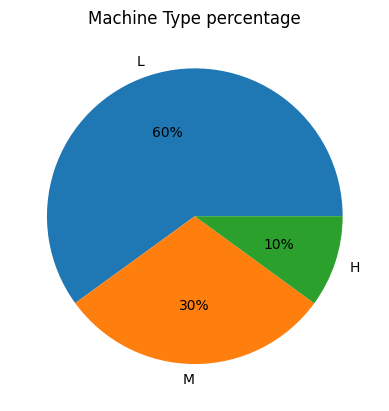

In [ ]:
# Pie chart of Type percentage
value = data['Type'].value_counts()
Type_percentage = 100*value/data.Type.shape[0]
labels = Type_percentage.index.array
x = Type_percentage.array
plt.pie(x, labels = labels, colors=sns.color_palette('tab10')[0:3], autopct='%.0f%%')
plt.title('Machine Type percentage')
plt.show()

**QUESTION:** Display the distribution of machine failures and non-failures with a bar graph.

Machine failure
0    9661
1     339
Name: count, dtype: int64


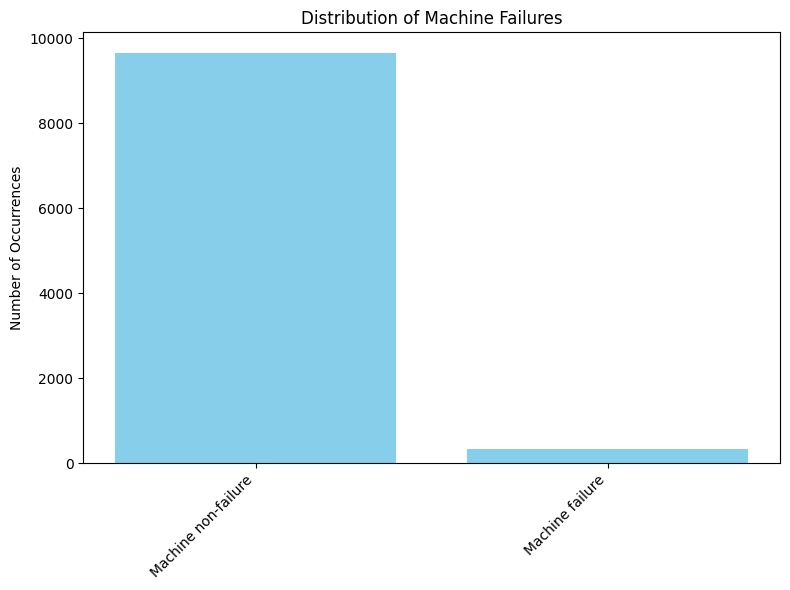

In [ ]:
#count the occurrences of each failure type
failure_counts = data['Machine failure'].value_counts()
print(failure_counts) #1 = broken machine
lab = ['Machine non-failure', 'Machine failure']

#plot graph
plt.figure(figsize=(8, 6))
plt.bar(lab, failure_counts.values, color = "skyblue")
plt.xlabel("")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Machine Failures")
plt.xticks(rotation=45, ha="right") #rotation of x label for better read.
plt.tight_layout()
plt.show()


**ANALYSIS QUESTION:** What do you observe?

we can observe that the dataset is highly imbalanced, with failures making up only ~3.5% of the total data.

**ANALYSIS QUESTION:** What will be the consequence of this phenomenon on the model's learning?

This could lead to a bias in machine learning models, where they might predict "no failure" most of the time and still achieve high accuracy but fail to detect real failures.

**QUESTION:** Create a bar chart showing the distribution of different failure types (TWF, HDF, PWF, OSF, RNF). Display the exact values above each bar in the chart."

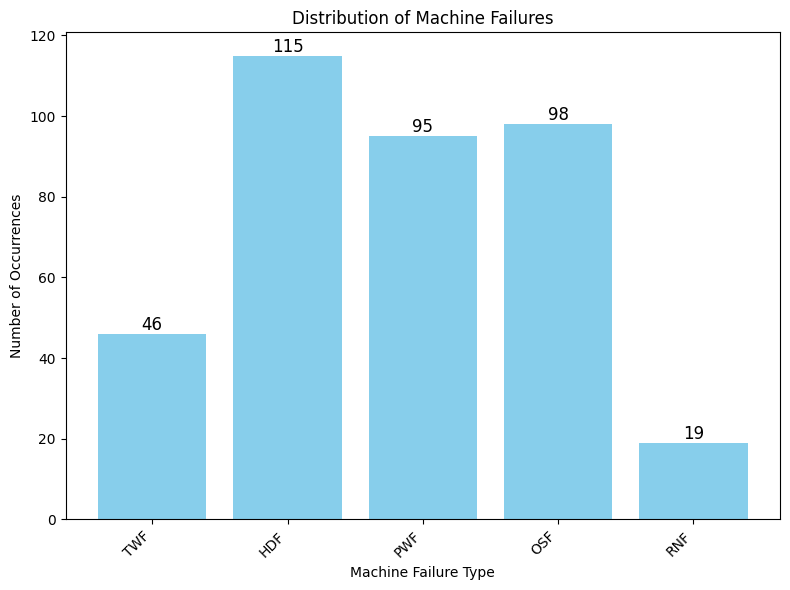

In [ ]:
#failure types list
failure_types = ['TWF', 'HDF', 'PWF', 'OSF', 'RNF']

#occurrences of each failure type
failure_counts = data[failure_types].sum()

#plot graph
plt.figure(figsize=(8, 6))
bars = plt.bar(failure_types, failure_counts.values, color = 'skyblue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom', fontsize=12)

plt.xlabel("Machine Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Machine Failures")
plt.xticks(rotation=45, ha="right")  #rotate x (lisibility)
plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** What do you observe?

Among the failure types, HDF, PWF and OSF are predominants. Hence, we can expect those failures to be predicted more frequently than the others, by the model.

**QUESTION:** Create a bar chart showing the distribution of failure types (TWF, HDF, PWF, OSF, RNF) among machines that experienced a failure (Machine failure == 1). Additionally, add a "No Specific Failure" category to count cases where a machine failed but no specific failure type was recorded. Display the exact values above each bar in the chart."

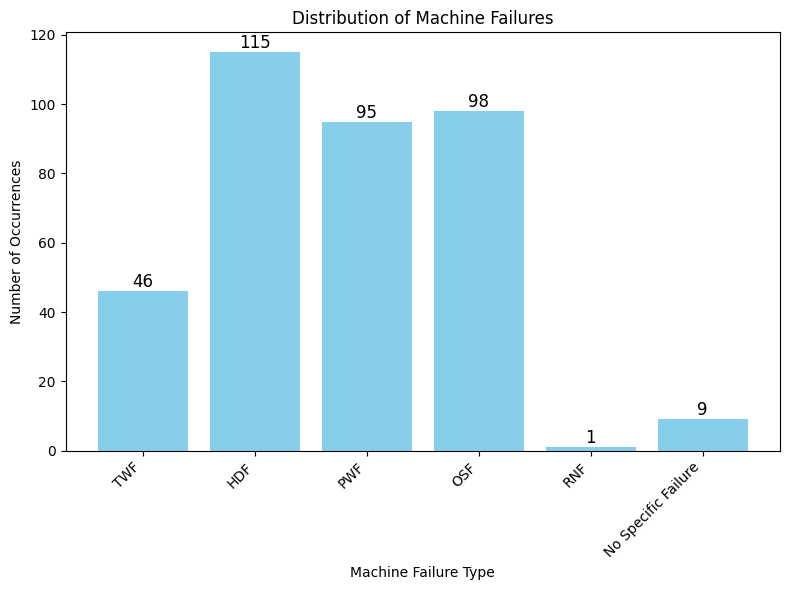

In [ ]:
#machines that experienced a failure
failed_machines = data[data['Machine failure'] == 1]
failure_counts = failed_machines[failure_types].sum()

#no specific failure
no_specific_failure_count = (failed_machines[failure_types].sum(axis=1) == 0).sum()
failure_counts['No Specific Failure'] = no_specific_failure_count

#chart
plt.figure(figsize=(8, 6))
bars = plt.bar(failure_counts.index, failure_counts.values, color='skyblue')
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), str(int(bar.get_height())),
             ha='center', va='bottom', fontsize=12)

# Labels and title
plt.xlabel("Machine Failure Type")
plt.ylabel("Number of Occurrences")
plt.title("Distribution of Machine Failures")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

**ANALYSIS QUESTION:** What do you obsrve comapred to the previous question ? What can you conclude?

We can observe two main problems here :
- Compared to the previous question, we can notice that 9 machines faced a failure with no specific explanation behind. It represents 3% of the total amount of failures. Thus, our model will have at least a 3% margin error.

- Moreover, we seem to have lost 10 failure occurences (the previous chart reported 19 random RNF failures ). So, when the failure is random (RNF), the `Machine Failure` feature is not set to 1 systematically.

Fortunately the machine failure RNF occurs in only 1 observation and it has a random nature therefore not predictable so we could decide to remove these rows in the future model. The same applies for our 9 RNF non machine failure.

**QUESTION:** Display the names of the different columns in the dataset with their respective data types.

In [ ]:
print(data.dtypes)

UDI                          int64
Product ID                  object
Type                        object
Air temperature [K]        float64
Process temperature [K]    float64
Rotational speed [rpm]       int64
Torque [Nm]                float64
Tool wear [min]              int64
Machine failure              int64
TWF                          int64
HDF                          int64
PWF                          int64
OSF                          int64
RNF                          int64
dtype: object


**ANALYSIS QUESTION:** To train the model, what will be the inputs and outputs (What are the names of the columns that you will use?)? Justify your response.
Remember, you want to predict if the machine will fail, and if so, what kind of failure. You need to yse previous results to jsurtify your response.

To predict whether a machine will fail and determine the type of failure, we must choose features that influence failures. The most relevant input features (so our Xs) are:

- `Air temperature [K]`
- `Process temperature [K]`
- `Rotational speed [rpm]`
- `Torque [Nm]`
- `Tool wear [min]`

Of course, we exclude columns like `Product ID` that is nowhere near relevant for our training, since it is unrealistic to think that the failure of a machine depends on its identifier.

`UDI` is a copy of the dataframe index, we can also get rid of it. The column `Product ID` is made up of an initial letter followed by five numbers, which could have meant somehting. However, the initial letter in the `Product ID` represents the machine Type, while the number sequences are divided into three intervals based on the same feature which confirms that the Product ID column does not provide additional info. We can remove it.


As for our outputs, we expect to receive wether we encounter a machine failure or not and if so, one of the 4 failure causes (we'll see later how we will get rid of the "RNF" one). Our labels will be `["No error", TWF', 'HDF', 'PWF', 'OSF']`.

## **2- Train model Without balancing the dataset**

---



In this section, you must build and train a model without rebalancing the dataset.

Before training, we need to do a bit of cleaning. Therefore, in this section we will be trying to clean the dataset as much as possible, without acting on any of the imbalances yet (so no consideration regarding the extremely low occurrence of machine failures among the entire dataset). As previously said, we will only be removing the rows correponding to the two problems above.

**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [ ]:
#input features and outputs
input_features = ['Air temperature [K]', 'Process temperature [K]',
                  'Rotational speed [rpm]', 'Torque [Nm]', 'Tool wear [min]']

output_labels = ["No error", 'TWF', 'HDF', 'PWF', 'OSF']

#problem 1 : we drop the observations where RNF=1 but Machine failure=0
idx_RNF = data.loc[(data["RNF"] == 1) & (data["Machine failure"] == 0)].index
data.drop(index=idx_RNF, inplace=True)
#problem 2 : we drop the observations where Machine failure is set to 1 when all types of failures are set to 0
idx_unknown_failure = data.loc[(data["Machine failure"] == 1) & (data[failure_types].sum(axis=1) == 0)].index
data.drop(index=idx_unknown_failure, inplace=True)

#now let's create our input/output
#X (inputs)
X = data[input_features].values #conv dataframe to array

#Y
Y = data[failure_types].copy()
no_error_condition = (Y == 0).all(axis=1) #no error condition to handle the case where no failure happens
Y = np.where(no_error_condition, 'No Error', Y.idxmax(axis=1))
Y = pd.get_dummies(Y) #we need to convert it to one-hot


#split into training and test sets (we arbitrary choose 80% train, 20% test)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

#print
print(f"X_train shape: {X_train.shape}")
print(f"Y_train shape: {Y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"Y_test shape: {Y_test.shape}")

X_train shape: (7978, 5)
Y_train shape: (7978, 5)
X_test shape: (1995, 5)
Y_test shape: (1995, 5)


Comment : Our actions did not alterate the original data very much (originally, we would have had :
- X_train shape: (8000, 5)
- Y_train shape: (8000, 5)
- X_test shape: (2000, 5)
- Y_test shape: (2000, 5))


**QUESTION** Code below the model architecture

Here, we define a simple MLP model with relu activation and sigmoid output for binary classification.

In [ ]:
#model architecture
model = Sequential([
    Dense(64, activation='relu', input_shape=(X_train.shape[1],)),  #hidden layer
    Dropout(0.2),  #dropout
    Dense(32, activation='relu'),  #hidden layer
    #Dense(50, activation='relu'),  #hidden layer
    Dense(Y_train.shape[1], activation='sigmoid')  #output layer
])

#Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#Display model summary
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 64)                384       
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_11 (Dense)            (None, 32)                2080      
                                                                 
 dense_12 (Dense)            (None, 5)                 165       
                                                                 
Total params: 2,629
Trainable params: 2,629
Non-trainable params: 0
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model

**WARNING!** You need to plot the training and test accuracy and loss to check if our model is overfitting

Epoch 1/20
250/250 [==============================] - 5s 5ms/step - loss: 6.3380 - accuracy: 0.9194 - val_loss: 1.3720 - val_accuracy: 0.9704
Epoch 2/20
250/250 [==============================] - 1s 3ms/step - loss: 1.3478 - accuracy: 0.9545 - val_loss: 0.7465 - val_accuracy: 0.9704
Epoch 3/20
250/250 [==============================] - 1s 2ms/step - loss: 0.8391 - accuracy: 0.9559 - val_loss: 0.5123 - val_accuracy: 0.9704
Epoch 4/20
250/250 [==============================] - 1s 3ms/step - loss: 0.5821 - accuracy: 0.9560 - val_loss: 0.3434 - val_accuracy: 0.9704
Epoch 5/20
250/250 [==============================] - 1s 3ms/step - loss: 0.3929 - accuracy: 0.9573 - val_loss: 0.2510 - val_accuracy: 0.9704
Epoch 6/20
250/250 [==============================] - 1s 3ms/step - loss: 0.2718 - accuracy: 0.9565 - val_loss: 0.1333 - val_accuracy: 0.9704
Epoch 7/20
250/250 [==============================] - 1s 2ms/step - loss: 0.1920 - accuracy: 0.9573 - val_loss: 0.1176 - val_accuracy: 0.9704
Epoch 

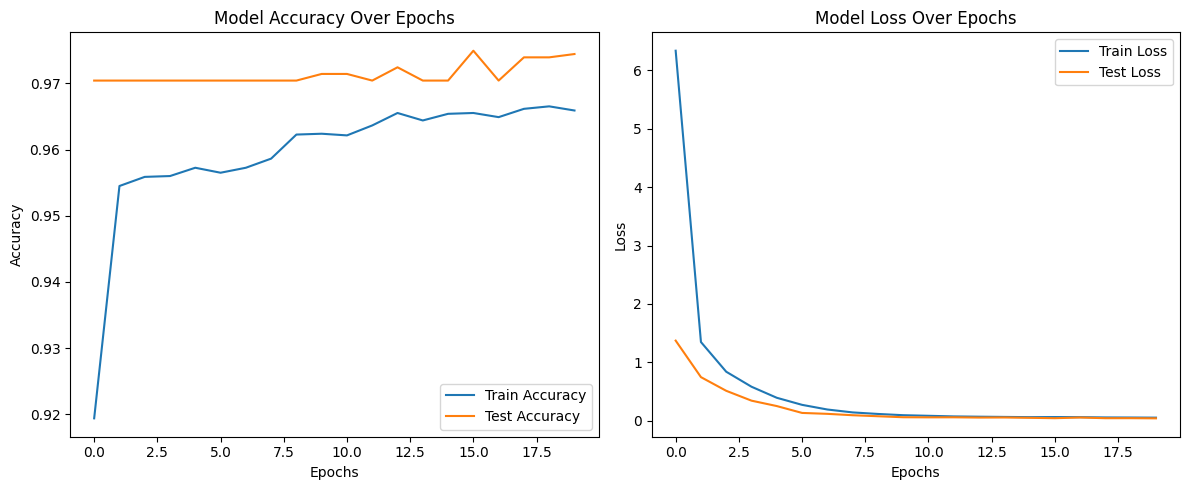

In [ ]:
#training of the model
history = model.fit(X_train, Y_train, epochs=20, batch_size=32, validation_data=(X_test, Y_test))

#plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()

#plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()

#ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = model.evaluate(X_train, Y_train, batch_size=32)
loss_test, acc_test = model.evaluate(X_test, Y_test, batch_size=32)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)

plt.tight_layout()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

**Tips:**

*   classification report link

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html

*   Matrix confusion

> https://scikit-learn.org/stable/modules/generated/sklearn.metrics.ConfusionMatrixDisplay.html





Here, we got a problem of multi-label classification. We can either create a confusion matrix and classification report for each class or a single matrix and classification for all six classes. We chose the latter.

> **_note:_**   (a good tutorial that helped us understand : https://towardsdatascience.com/evaluating-multi-label-classifiers-a31be83da6ea/)


{0: 'HDF', 1: 'No Error', 2: 'OSF', 3: 'PWF', 4: 'TWF'} 

63/63 [==============================] - 0s 1ms/step


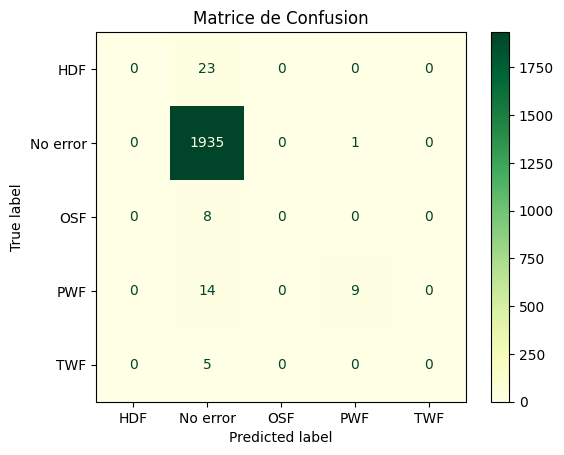

              precision    recall  f1-score   support

         HDF       0.00      0.00      0.00        23
    No error       0.97      1.00      0.99      1936
         OSF       0.00      0.00      0.00         8
         PWF       0.90      0.39      0.55        23
         TWF       0.00      0.00      0.00         5

    accuracy                           0.97      1995
   macro avg       0.37      0.28      0.31      1995
weighted avg       0.96      0.97      0.96      1995



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [ ]:
#we first need to figure out which class is which (because of the encoding from 0 to 4)
class_mapping = {i: label for i, label in enumerate(Y.columns)}
print(class_mapping, "\n")

#predictions
y_pred = model.predict(X_test)
#prediction to label index
y_pred_int = np.argmax(y_pred, axis=1)

# one hot to real numbers
Y_test_int = np.argmax(Y_test, axis=1)

output_labels = ['HDF', 'No error', 'OSF', 'PWF', 'TWF' ]

#confusion matrix
cm = confusion_matrix(Y_test_int, y_pred_int, labels=np.arange(len(output_labels)))
#print(cm)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=output_labels)
disp.plot(cmap=plt.cm.YlGn)
plt.title("Matrice de Confusion")
plt.show()

# Affichage du rapport de classification
print(classification_report(Y_test_int, y_pred_int, target_names=output_labels, labels=np.arange(5)))


**ANALYSIS QUESTION** What do you observe? What can you conclude?

As we already knew, our model is completely biased toward predicting only the "No error" class. The overall accuracy is ~99%, but this is wrong because the model simply learned to always predict the latter, which dominates the dataset, so it's not recognizing any of the other classes at all. We can suggest that all "No error" were (correctly?) classified, while all other classes have only zeros or close to zero valeus, meaning they were never predicted.


Therefore, the next move will be to address our class imbalance problem.

## **3- Train model With balancing the dataset**

---

 Methods for rebalancing a dataset:


*   Use oversampling techniques (e.g., SMOTE) to generate synthetic data for minority classes


> https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html



*   Apply undersampling techniques (e.g., random undersampling, Tomek Links, Edited Nearest Neighbors) to reduce the majority class size



> https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html



*   Use class weighting during model training to penalize errors on minority classes



> https://www.tensorflow.org/tutorials/structured_data/imbalanced_data?hl=fr


**QUESTION:** Create X_train, Y_train, X_test, and Y_test. How many elements are present in X_train, Y_train, X_test, and Y_test? (Print the values)

In [47]:
class_mapping = {i: label for i, label in enumerate(Y.columns)}
print("As a reminder : ", class_mapping, "\n")

#let's keep our clean X and Y data and slip into a new training and test sets (we'll just add a _B for "balanced")
X_train_B, X_test_B, Y_train_B, Y_test_B = train_test_split(X, Y, test_size=0.2, random_state=42)
print("Original class distrib:", Counter(np.argmax(Y_train_B, axis=1)))

#SMOTE
smote = SMOTE(random_state=42)
X_train_r, Y_train_r = smote.fit_resample(X_train_B, np.argmax(Y_train_B, axis=1))

#convert Y back to one-hot encoding
Y_train_r = to_categorical(Y_train_r)
Y_test_B = to_categorical(np.argmax(Y_test_B, axis=1))  # to make sure the test labels stay in the correct format
print("Balanced class distribution:", Counter(np.argmax(Y_train_r, axis=1)))


print(f"X_train_r shape: {X_train_r.shape}")
print(f"Y_train_r shape: {Y_train_r.shape}")  # Should be (n, 5) if 5 classes
print(f"X_test_B shape: {X_test_B.shape}")
print(f"Y_test_B shape: {Y_test_B.shape}")

As a reminder :  {0: 'HDF', 1: 'No Error', 2: 'OSF', 3: 'PWF', 4: 'TWF'} 

Original class distrib: Counter({1: 7707, 0: 92, 2: 70, 3: 68, 4: 41})
Balanced class distribution: Counter({1: 7707, 4: 7707, 0: 7707, 2: 7707, 3: 7707})
X_train_r shape: (38535, 5)
Y_train_r shape: (38535, 5)
X_test_B shape: (1995, 5)
Y_test_B shape: (1995, 5)


### Bonus :
Let's visualize it better :

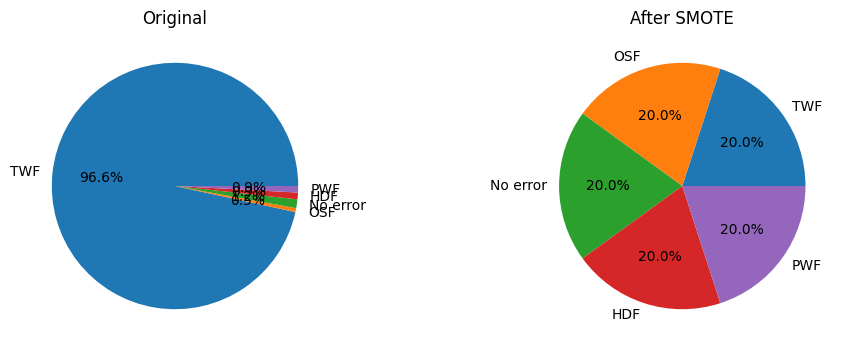

In [48]:
#before SMOTE
original_counts = Counter(np.argmax(Y_train_B, axis=1))
original_total = sum(original_counts.values())
fail_percentage_before = {k: (v / original_total) * 100 for k, v in original_counts.items()}

#after SMOTE
resampled_counts = Counter(np.argmax(Y_train_r, axis=1))
resampled_total = sum(resampled_counts.values())
fail_percentage_after = {k: (v / resampled_total) * 100 for k, v in resampled_counts.items()}

#labels and stuff
class_labels = output_labels

#chart ------
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
#og
axs[0].pie(fail_percentage_before.values(), labels=[class_labels[k] for k in fail_percentage_before.keys()],
           colors=sns.color_palette('tab10'), autopct='%.1f%%')
axs[0].title.set_text('Original')
#resamble
axs[1].pie(fail_percentage_after.values(), labels=[class_labels[k] for k in fail_percentage_after.keys()],
           colors=sns.color_palette('tab10'), autopct='%.1f%%')
axs[1].title.set_text('After SMOTE')

plt.show()

**ANALYSIS QUESTION:** Explain the choices you made to balance the dataset.

To address the class imbalance, we used SMOTE to generate synthetic samples for minority classes. This ensures that all classes have an equal number of samples, which will prevent the model from being biased toward the majority class. We found out that the SMOTE procedure worked as follows: it picks a random sample from the minority class and for the observations in this sample, identifies the k nearest neighbors. It will then take one of those neighbors and identify the vector between the current data point and the selected neighbor. The vector will be multiplied by a random number between 0 and 1 and the synthetic data point is obtained by adding this vector to the current data point.


Now, why did we chose SMOTE over undersampling ? SMOTE preserves all data while generating 'fake' samples for minority classes, therefore preventing loss of important information. Undersampling, on the other hand, removes majority class data, which can lead to loss of variability and underfitting, especially in small datasets. Since failures are rare, SMOTE helps balance the dataset without discarding useful observations.

**QUESTION:** Code below the model architecture


**TIP:** It could be interesting to keep it the same as before

In [49]:
#model architecture
model_B = Sequential([
    Dense(32, activation='relu', input_shape=(X_train_r.shape[1],)),  # Hidden layer
    Dense(64, activation='relu'),  # Hidden layer
    Dense(128, activation='relu'),
    Dropout(0.3),  # Dropout
    Dense(Y_train_r.shape[1], activation='sigmoid')  # Output layer
])

#another test to see if we had better results :
# model_B = Sequential([
#     Dense(16, activation='relu', kernel_regularizer=l2(0.001), input_shape=(X_train_over.shape[1],)),
#     BatchNormalization(),
#     Dropout(0.3),

#     Dense(8, activation='relu', kernel_regularizer=l2(0.001)),
#     BatchNormalization(),
#     Dropout(0.3),

#     Dense(Y_train_over.shape[1], activation='softmax')
# ])

# Compile the model
model_B.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model_B.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 32)                192       
                                                                 
 dense_14 (Dense)            (None, 64)                2112      
                                                                 
 dense_15 (Dense)            (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_16 (Dense)            (None, 5)                 645       
                                                                 
Total params: 11,269
Trainable params: 11,269
Non-trainable params: 0
_________________________________________________________________


**QUESTION** Code below the algorithms allowing to train model


Epoch 1/20
1205/1205 [==============================] - 6s 4ms/step - loss: 0.9213 - accuracy: 0.6052 - val_loss: 0.2405 - val_accuracy: 0.7258
Epoch 2/20
1205/1205 [==============================] - 3s 2ms/step - loss: 0.2938 - accuracy: 0.6807 - val_loss: 0.2126 - val_accuracy: 0.7654
Epoch 3/20
1205/1205 [==============================] - 3s 2ms/step - loss: 0.2722 - accuracy: 0.7158 - val_loss: 0.2850 - val_accuracy: 0.7078
Epoch 4/20
1205/1205 [==============================] - 3s 2ms/step - loss: 0.2328 - accuracy: 0.7789 - val_loss: 0.2430 - val_accuracy: 0.7338
Epoch 5/20
1205/1205 [==============================] - 3s 2ms/step - loss: 0.1895 - accuracy: 0.8318 - val_loss: 0.1833 - val_accuracy: 0.7719
Epoch 6/20
1205/1205 [==============================] - 4s 3ms/step - loss: 0.1627 - accuracy: 0.8592 - val_loss: 0.2506 - val_accuracy: 0.7348
Epoch 7/20
1205/1205 [==============================] - 3s 2ms/step - loss: 0.1450 - accuracy: 0.8784 - val_loss: 0.2751 - val_accuracy:

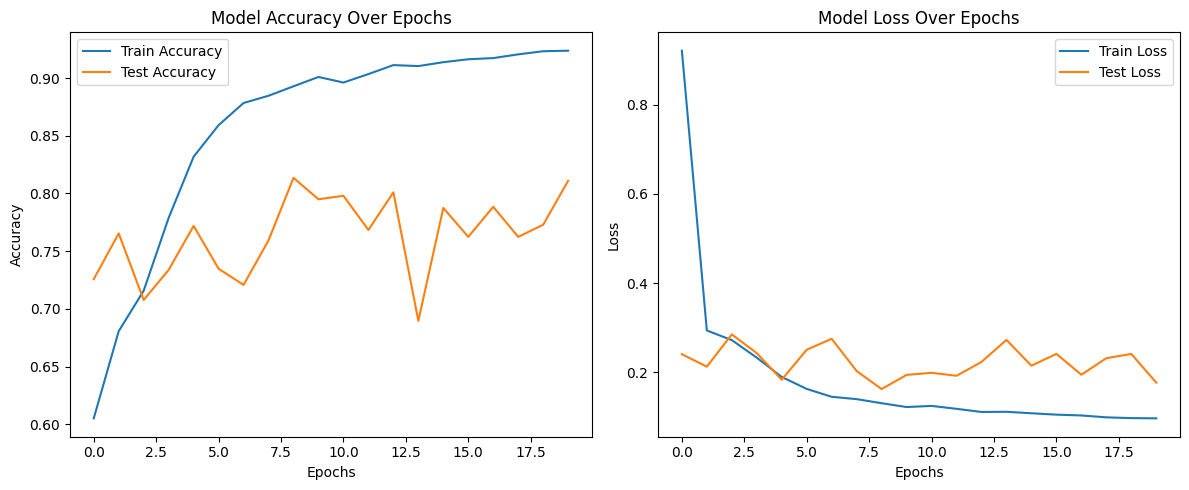

In [50]:
#training of the model
history = model_B.fit(X_train_r, Y_train_r, epochs=20, batch_size=32, validation_data=(X_test_B, Y_test_B))

#plot training & validation accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Test Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy Over Epochs")
plt.legend()

#plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Test Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss Over Epochs")
plt.legend()

#ACCURACY ON THE TRAINING AND TEST SETS
loss_train, acc_train = model.evaluate(X_train, Y_train, batch_size=32)
loss_test, acc_test = model.evaluate(X_test, Y_test, batch_size=32)

print("Performance on the TRAIN set, ACCURACY=", acc_train)
print("Performance on the TEST set, ACCURACY=", acc_test)

plt.tight_layout()
plt.show()

**QUESTION** Plot the confusion matrix and the classification report

This time, we'll do a class report and a confusion matrix per class (so 6 in total) in order to better understand the implications of it.

63/63 [==============================] - 0s 3ms/step
classification Report:
              precision    recall  f1-score   support

         HDF       0.01      1.00      0.02        23
    No error       0.00      0.00      0.00      1936
         OSF       0.00      0.00      0.00         8
         PWF       0.00      0.00      0.00        23
         TWF       0.00      0.00      0.00         5

    accuracy                           0.01      1995
   macro avg       0.00      0.20      0.00      1995
weighted avg       0.00      0.01      0.00      1995



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


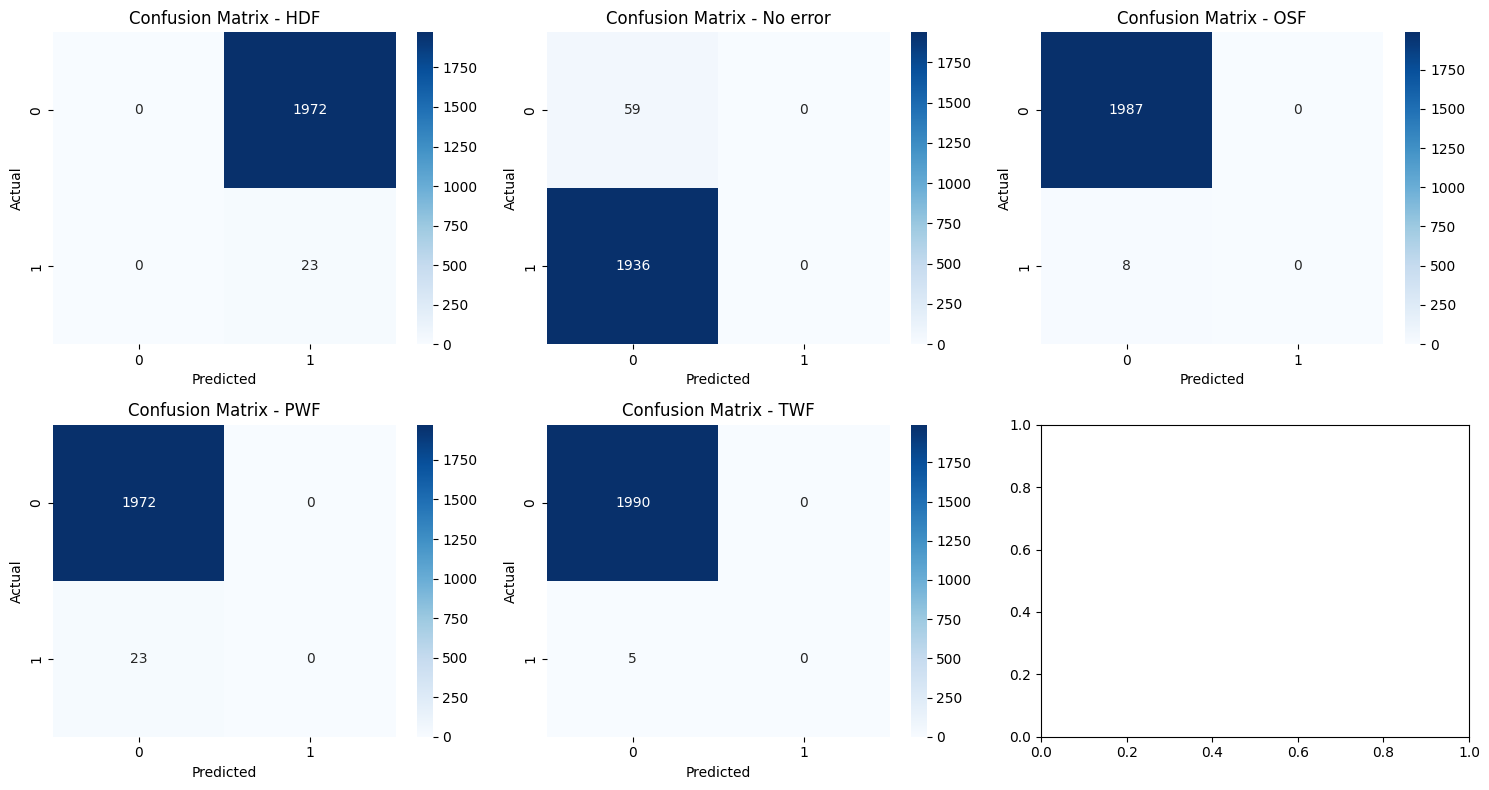

In [56]:
#get predictions
Y_pred = model.predict(X_test_B)
Y_pred_classes = np.argmax(Y_pred, axis=1)
Y_true_classes = np.argmax(Y_test_B, axis=1)  #one-hot labels to class indices


output_labels = ['HDF', 'No error', 'OSF', 'PWF', 'TWF' ]

#Classification report
print("classification Report:")
print(classification_report(Y_true_classes, Y_pred_classes, target_names=output_labels))

#one confusion matrix per output
num_classes = len(output_labels)
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.ravel() #flatten

for i in range(num_classes):
    cm = confusion_matrix(Y_true_classes == i, Y_pred_classes == i)

    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[i])
    axes[i].set_title(f"Confusion Matrix - {output_labels[i]}")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")

plt.tight_layout()
plt.show()


**ANALYSIS QUESTION** What do you observe? What can you conclude?

"Write your response here"

### Save our model

In [ ]:
np.save("X_test_pred.npy", X_test_B)
np.save("Y_test_pred.npy", Y_test_B)
model.save("pred_model.h5")